# 타이타닉 생존자 예측 모델

![image](titanic_structure.png)

라이브러리

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

## 1. Preparing dataset 

In [2]:
data_df = pd.read_csv('titanic.csv')
data_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### 컬럼 정보
- PassengerId : 각 승객 고유번호
- Survived : 생존여부
- Pclass : 객실 등급 (1 / 2 / 3)
- Name : 승객 이름
- Sex : 성별
- Age : 나이
- SibSp : 동반한 형재자매, 배우자 수
- Parch : 동반한 부모, 자식 수
- Ticket : 티켓 고유번호
- Fare : 티켓 요금
- Cabin : 객실 번호
- Embarked : 승선한 항 (C-Cherbourg / Q-Queenstown / S-Southampton)

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
y_data = data_df[['Survived']]
y_data.head(3)

,Survived
0,0
1,1
2,1


In [5]:
del data_df['Survived']
X_data = data_df.copy()
X_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<br>

## 2. Feature engineering & Feature selection

### 2-1. 결측치 확인

In [6]:
data_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
import quilt
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data_df)

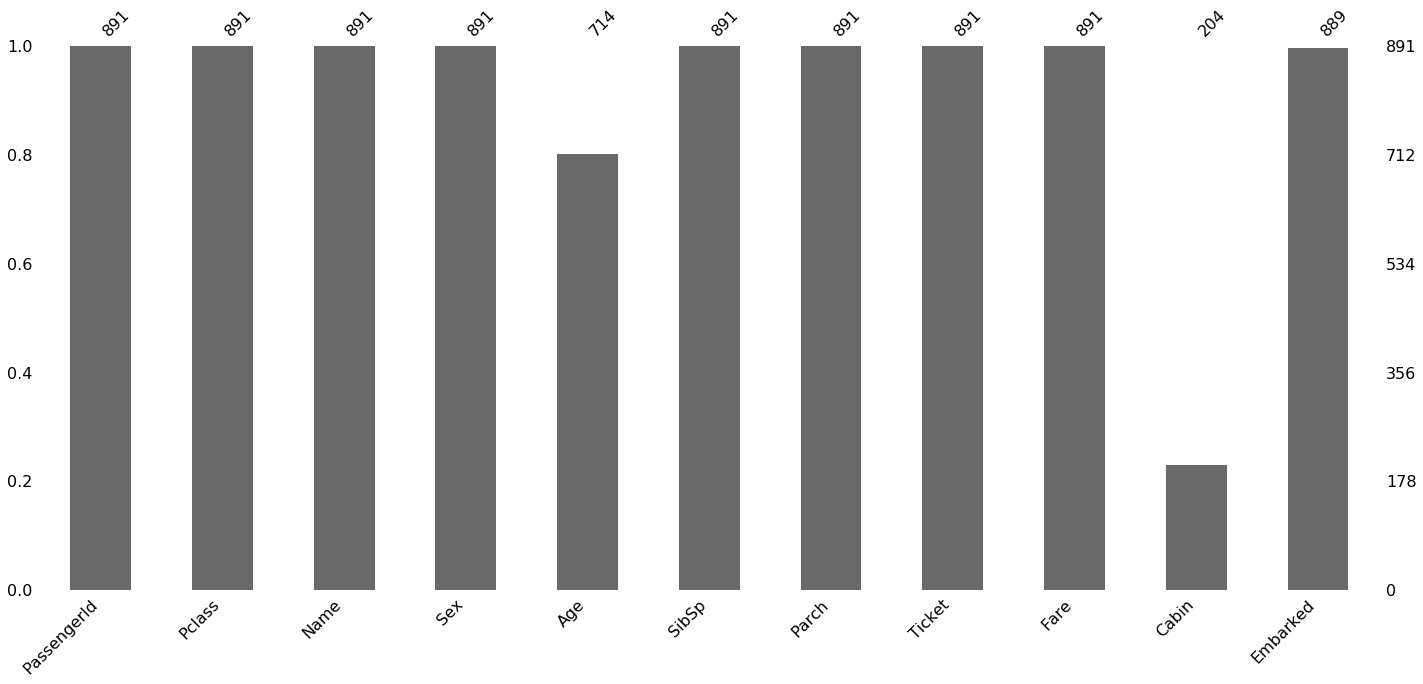

In [8]:
msno.bar(data_df)

결측치가 있는 열: Age, Cabin, Embarked

In [9]:
# 원본 데이터 유지
data_df_copy = data_df.copy()

- Cabin(객실번호)

In [10]:
del data_df['Cabin']

- Embarked(승선한 항)

In [11]:
data_df[data_df.Embarked.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [12]:
# 두 승객과 동일한 1등급 승객들의 Embarked별 Fare 평균 구하여 비교

# 1등급 승객
class1st = data_df[data_df.Pclass == 1]

# 1등급 승객 중 각 Embarked별 Fare 평균
class1st_C = class1st[class1st.Embarked == 'C']['Fare'].mean()
class1st_S = class1st[class1st.Embarked == 'S']['Fare'].mean()
class1st_Q = class1st[class1st.Embarked == 'Q']['Fare'].mean()

print("Boarded from Cherbourg:", class1st_C)
print("Boarded from Southampton:", class1st_S)
print("Boarded from Queenstown:", class1st_Q)

Boarded from Cherbourg: 104.71852941176469
Boarded from Southampton: 70.36486220472443
Boarded from Queenstown: 90.0


In [13]:
# 1등급 승객 중 S와 Q 두 Embarked의 비율 계산

# df.shape[0] >> 행의 수 (전체 데이터 수)
print("Southampton:", str(round(class1st[class1st['Embarked'] == 'S'].shape[0] / class1st.shape[0]*100, 2)) + "%")
print("Queenstown:", str(round(class1st[class1st['Embarked'] == 'Q'].shape[0] / class1st.shape[0]*100, 2)) + "%")

Southampton: 58.8%
Queenstown: 0.93%


In [14]:
# 비율이 높은 S로 대체

data_df['Embarked'][61] = 'S'
data_df['Embarked'][829] = 'S'

- Age(나이)

이름 그룹별로 나눠서 나이 평균 계산 <br>
나이 정보가 없는 승객의 경우 해당 승객이 속한 이름 그룹의 나이 평균값으로 정보 대체

In [15]:
data_df[data_df.Age.isnull()].head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
17,18,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S
19,20,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,C
26,27,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,C
28,29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Q


In [16]:
# 이름에 포함된 Mr, Mrs, Miss 등으로 그룹화

def get_name_group(name):
    start = name.find(', ')
    end = name.find('.')
    return name[start+1:end]

data_df['name_group'] = data_df.Name.apply(get_name_group)

data_df[['Name', 'name_group']].head()

,Name,name_group
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [17]:
# 이름 그룹별 나이 평균
age_group_mean = dict(data_df.groupby(['name_group'])['Age'].mean())
age_group_mean

{' Capt': 70.0,
 ' Col': 58.0,
 ' Don': 40.0,
 ' Dr': 42.0,
 ' Jonkheer': 38.0,
 ' Lady': 48.0,
 ' Major': 48.5,
 ' Master': 4.574166666666667,
 ' Miss': 21.773972602739725,
 ' Mlle': 24.0,
 ' Mme': 24.0,
 ' Mr': 32.368090452261306,
 ' Mrs': 35.898148148148145,
 ' Ms': 28.0,
 ' Rev': 43.166666666666664,
 ' Sir': 49.0,
 ' the Countess': 33.0}

In [18]:
# 자신의 이름이 속한 그룹의 평균으로 대체

for index in data_df[data_df.Age.isnull()].index:
    name = data_df.loc[index, 'name_group']
    data_df.loc[index, 'Age'] = age_group_mean[name]

In [19]:
data_df[data_df.Age.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,name_group


<br>

### 2-2. feature 수치화, 범주화

- Sex(성별)

In [20]:
data_df['Sex']=data_df['Sex'].replace(['male', 'female'], [0, 1])

- Age(나이)

In [21]:
data_df.Age.describe()

count    891.000000
mean      29.754659
std       13.277179
min        0.420000
25%       21.773973
50%       30.000000
75%       35.898148
max       80.000000
Name: Age, dtype: float64

In [22]:
data_df['age_group'] = data_df['Age'].apply(lambda x: int(x/10))

data_df[['Age', 'age_group']].head()

,Age,age_group
0,22.0,2
1,38.0,3
2,26.0,2
3,35.0,3
4,35.0,3


In [23]:
data_df.age_group.value_counts()

3    303
2    256
1    102
4     90
0     66
5     48
6     19
7      6
8      1
Name: age_group, dtype: int64

- Embarked(승선한 항)

In [24]:
data_df.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [25]:
def embarked_categorized(em):
    if em == 'S':
        return 0
    elif em == 'C':
        return 1
    else:
        return 2

data_df['emb_cat'] = data_df.Embarked.apply(embarked_categorized)
data_df[['Embarked', 'emb_cat']].head()

,Embarked,emb_cat
0,S,0
1,C,1
2,S,0
3,S,0
4,S,0


- SibSp & Parch - Companion (동행자)

In [26]:
# 티켓 번호가 같을 시 일행으로 봤을 때 동일한 티켓을 지닌 승객 수를 일행(companion) 수라고 가정

count_dict = dict(data_df['Ticket'].value_counts())
data_df['companion'] = data_df['Ticket'].apply(lambda  x : count_dict[x])

In [27]:
# sibsp, parch 둘다 0 이고 티켓 넘버 같은 것도 없을 경우 일행 없는 것으로 간주
# 일행이 없을 때 0, 나머지는 1(일행있음)
data_df['companion'] = [0 if data_df['SibSp'][x] == 0 and data_df['Parch'][x] == 0 and count_dict[data_df['Ticket'][x]] == 1 else 1 for x in data_df.index ]

- Fare(요금)

In [104]:
data_df['fare_cat'].value_counts()

1    184
3    180
0    179
4    176
2    172
Name: fare_cat, dtype: int64

In [28]:
data_df['fare_cat'] = pd.qcut(data_df['Fare'], 5)
data_df['fare_cat'] = data_df['fare_cat'].astype('category').cat.codes

data_df[['Fare', 'fare_cat']].head()

,Fare,fare_cat
0,7.2500,0
1,71.2833,4
2,7.9250,1
3,53.1000,4
4,8.0500,1


<br>

### 2-3. feature selection

In [29]:
data_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,name_group,age_group,emb_cat,companion,fare_cat
0,1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S,Mr,2,0,1,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,Mrs,3,1,1,4
2,3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,2,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S,Mrs,3,0,1,4
4,5,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S,Mr,3,0,0,1


In [30]:
data_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'name_group', 'age_group', 'emb_cat',
       'companion', 'fare_cat'],
      dtype='object')

In [31]:
X_data = data_df[['Pclass', 'Sex', 'age_group', 'fare_cat', 'emb_cat', 'companion']]
X_data.head(3)

,Pclass,Sex,age_group,fare_cat,emb_cat,companion
0,3,0,2,0,0,1
1,1,1,3,4,1,1
2,3,1,2,1,0,0


<br>

## 3. Train / Test Split

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

<br>

## 4. Create Model & Train & Predict

In [34]:
import warnings 
warnings.filterwarnings(action='ignore')

from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

#### K-fold

In [35]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

### 4-1. kNN

In [36]:
clf_kNN = KNeighborsClassifier(n_neighbors = 13)
scoring = 'accuracy'
score = cross_val_score(clf_kNN, X_data, y_data, cv=k_fold, n_jobs=1, scoring=scoring)

print(round(np.mean(score)*100,2))

79.34


In [37]:
clf_kNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=13, p=2,
           weights='uniform')

In [38]:
predict_kNN = clf_kNN.predict(X_test)
accuracy_kNN = accuracy_score(y_test,predict_kNN)
accuracy_kNN

0.7873134328358209

In [105]:
clf_kNN.score(X_test, y_test)

0.7873134328358209

### 4-2. Desicion Tree

In [39]:
clf_DT = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf_DT, X_data, y_data, cv=k_fold, n_jobs=1, scoring=scoring)

print(round(np.mean(score)*100,2))

81.25


In [40]:
clf_DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [41]:
predict_DT = clf_DT.predict(X_test)
accuracy_DT = accuracy_score(y_test,predict_DT)
accuracy_DT

0.8059701492537313

### 4-3. Random Forest

In [42]:
clf_RF = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf_RF, X_data, y_data, cv=k_fold, n_jobs=1, scoring=scoring)

print(round(np.mean(score)*100,2))

82.04


In [43]:
clf_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
predict_RF = clf_RF.predict(X_test)
accuracy_RF = accuracy_score(y_test,predict_RF)
accuracy_RF

0.8246268656716418

### 4-4. Naive Bayes

In [45]:
clf_NB = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf_NB, X_data, y_data, cv=k_fold, n_jobs=1, scoring=scoring)

print(round(np.mean(score)*100,2))

75.98


In [46]:
clf_NB.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [47]:
predict_NB = clf_NB.predict(X_test)
accuracy_NB = accuracy_score(y_test,predict_NB)
accuracy_NB

0.7723880597014925

### 4-5. SVM

In [48]:
clf_SVC = SVC(probability=True)
scoring = 'accuracy'
score = cross_val_score(clf_SVC, X_data, y_data, cv=k_fold, n_jobs=1, scoring=scoring)

print(round(np.mean(score)*100,2))

81.37


In [49]:
clf_SVC.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [50]:
predict_SVC = clf_SVC.predict(X_test)
accuracy_SVC = accuracy_score(y_test,predict_SVC)
accuracy_SVC

0.8059701492537313

### 4-6. LR

In [51]:
clf_LR = linear_model.LogisticRegression()
scoring = 'accuracy'
score = cross_val_score(clf_LR, X_data, y_data, cv=k_fold, n_jobs=1, scoring=scoring)

print(round(np.mean(score)*100,2))

78.68


In [52]:
clf_LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [53]:
predict_LR = clf_LR.predict(X_test)
accuracy_LR = accuracy_score(y_test,predict_LR)
accuracy_LR

0.7947761194029851

### 4-7. XGBoost

In [54]:
clf_XGB = XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3) 
scoring = 'accuracy'
score = cross_val_score(clf_XGB, X_data, y_data, cv=k_fold, n_jobs=1, scoring=scoring)

print(round(np.mean(score)*100,2))

81.37


In [55]:
clf_XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=0, silent=True, subsample=1)

In [56]:
predict_XGB = clf_XGB.predict(X_test)
accuracy_XGB = accuracy_score(y_test, predict_XGB)
accuracy_XGB

0.835820895522388

<br>

## 5. Model Ensemble - Stacking

In [57]:
print(accuracy_kNN)
print(accuracy_DT)
print(accuracy_RF)
print(accuracy_SVC)
print(accuracy_LR)
print(accuracy_NB)
print(accuracy_XGB)

0.7873134328358209
0.8059701492537313
0.8246268656716418
0.8059701492537313
0.7947761194029851
0.7723880597014925
0.835820895522388


In [68]:
accuracy_name = ['kNN', 'RF', 'SVC', 'LR', 'NB', 'XGB']
accuracy_list = list({accuracy_kNN, accuracy_RF, accuracy_SVC, accuracy_LR, accuracy_NB, accuracy_XGB})

accuracy_df = pd.DataFrame({'name': accuracy_name, 'accuracy': accuracy_list})

# 중복되서 들어가지 않은 값 따로 추가
accuracy_df = accuracy_df.append({'name': 'DT', 'accuracy': accuracy_DT}, ignore_index=True)

accuracy_df.sort_values(by='accuracy', ascending=False)

,name,accuracy
5,XGB,0.835821
1,RF,0.824627
3,LR,0.805970
6,DT,0.805970
2,SVC,0.794776
0,kNN,0.787313
4,NB,0.772388


### 5-1. kNN / RF / XGB

In [69]:
from vecstack import StackingTransformer

In [70]:
# Stage 1-1. 모델 생성
estimators = [
    ('KneighborsClassifier', KNeighborsClassifier(n_neighbors = 13)),
    ('RandomForest', RandomForestClassifier(random_state = 0, n_jobs = -1, n_estimators = 100, max_depth = 3)),
    ('XGB', XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3))]

In [71]:
# Stage 1-2. 모델 학습
stack = StackingTransformer(estimators, 
                            regression = False, 
                            metric = accuracy_score, 
                            n_folds = 4, stratified = True, shuffle = True, 
                            random_state = 0, verbose = 2) 
                            
stack = stack.fit(X_train, y_train)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [3]

estimator  0: [KneighborsClassifier: KNeighborsClassifier]
    fold  0:  [0.75796178]
    fold  1:  [0.77564103]
    fold  2:  [0.73548387]
    fold  3:  [0.81935484]
    ----
    MEAN:     [0.77211038] + [0.03076601]

estimator  1: [RandomForest: RandomForestClassifier]
    fold  0:  [0.77070064]
    fold  1:  [0.78846154]
    fold  2:  [0.83225806]
    fold  3:  [0.81290323]
    ----
    MEAN:     [0.80108087] + [0.02342003]

estimator  2: [XGB: XGBClassifier]
    fold  0:  [0.82802548]
    fold  1:  [0.81410256]
    fold  2:  [0.80000000]
    fold  3:  [0.83225806]
    ----
    MEAN:     [0.81859653] + [0.01266461]



In [72]:
# Stage 1-3. s_train / s_test 생성
S_train = stack.transform(X_train)
S_test = stack.transform(X_test)

Train set was detected.
Transforming...

estimator  0: [KneighborsClassifier: KNeighborsClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [RandomForest: RandomForestClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  2: [XGB: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

Transforming...

estimator  0: [KneighborsClassifier: KNeighborsClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [RandomForest: RandomForestClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimato

In [73]:
# Stage 2
model = XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3) 
model = model.fit(S_train, y_train) 
y_pred = model.predict(S_test) 

accuracy = accuracy_score(y_test, y_pred)

accuracy_df = accuracy_df.append({'name': 'Stacking', 'accuracy': accuracy}, ignore_index=True)
accuracy_df.sort_values(by='accuracy', ascending=False)

,name,accuracy
7,Stacking,0.839552
5,XGB,0.835821
1,RF,0.824627
3,LR,0.805970
6,DT,0.805970
2,SVC,0.794776
0,kNN,0.787313
4,NB,0.772388


### 2) kNN  / RF / SVC / LR / XGB

In [74]:
# Stage 1-1. 모델 생성
estimators = [
    ('KneighborsClassifier', KNeighborsClassifier(n_neighbors = 13)),
    ('RandomForest', RandomForestClassifier(random_state = 0, n_jobs = -1, n_estimators = 100, max_depth = 3)),
    ('SupportVectorClassifier', SVC()),
    ('LogisticRegression', linear_model.LogisticRegression()),
    ('XGB', XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3))]

In [75]:
# Stage 1-2. 모델 학습
stack = StackingTransformer(estimators, 
                            regression = False, 
                            metric = accuracy_score, 
                            n_folds = 4, stratified = True, shuffle = True, 
                            random_state = 0, verbose = 2) 
                            
stack = stack.fit(X_train, y_train)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [5]

estimator  0: [KneighborsClassifier: KNeighborsClassifier]
    fold  0:  [0.75796178]
    fold  1:  [0.77564103]
    fold  2:  [0.73548387]
    fold  3:  [0.81935484]
    ----
    MEAN:     [0.77211038] + [0.03076601]

estimator  1: [RandomForest: RandomForestClassifier]
    fold  0:  [0.77070064]
    fold  1:  [0.78846154]
    fold  2:  [0.83225806]
    fold  3:  [0.81290323]
    ----
    MEAN:     [0.80108087] + [0.02342003]

estimator  2: [SupportVectorClassifier: SVC]
    fold  0:  [0.82802548]
    fold  1:  [0.80128205]
    fold  2:  [0.81290323]
    fold  3:  [0.81935484]
    ----
    MEAN:     [0.81539140] + [0.00975440]

estimator  3: [LogisticRegression: LogisticRegression]
    fold  0:  [0.75796178]
    fold  1:  [0.77564103]
    fold  2:  [0.76774194]
    fold  3:  [0.81290323]
    ----
    MEAN:     [0.77856199] + [0.02079239]

estimator  4: [XGB: XGBClassifi

In [76]:
# Stage 1-3. s_train / s_test 생성
S_train = stack.transform(X_train)
S_test = stack.transform(X_test)

Train set was detected.
Transforming...

estimator  0: [KneighborsClassifier: KNeighborsClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [RandomForest: RandomForestClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  2: [SupportVectorClassifier: SVC]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  3: [LogisticRegression: LogisticRegression]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  4: [XGB: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

Transforming...

estimator  0: [Kneig

In [77]:
# Stage 2. 
model = XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3) 
model = model.fit(S_train, y_train) 
y_pred = model.predict(S_test) 

accuracy = accuracy_score(y_test, y_pred)

accuracy_df = accuracy_df.append({'name': 'Stacking_all', 'accuracy': accuracy}, ignore_index=True)
accuracy_df.sort_values(by='accuracy', ascending=False)

,name,accuracy
7,Stacking,0.839552
8,Stacking_all,0.839552
5,XGB,0.835821
1,RF,0.824627
3,LR,0.805970
6,DT,0.805970
2,SVC,0.794776
0,kNN,0.787313
4,NB,0.772388


<br>

## 6. Results Visualization

In [78]:
xgb_pred_test = clf_XGB.predict_proba(X_test)
svc_pred_test = clf_SVC.predict_proba(X_test)
knn_pred_test = clf_kNN.predict_proba(X_test)
rf_pred_test = clf_RF.predict_proba(X_test)

In [79]:
from sklearn.metrics import roc_curve, auc

xgb_fpr, xgb_tpr, _ = roc_curve(y_true=y_test, y_score=xgb_pred_test[:,1]) 
svc_fpr, svc_tpr, _3 = roc_curve(y_true=y_test, y_score=svc_pred_test[:,1])
knn_fpr, knn_tpr, _2 = roc_curve(y_true=y_test, y_score=knn_pred_test[:,1])
rf_fpr, rf_tpr, _4 = roc_curve(y_true=y_test, y_score=rf_pred_test[:,1])

xgb_roc_auc = auc(xgb_fpr, xgb_tpr)
svc_roc_auc = auc(svc_fpr, svc_tpr)
knn_roc_auc = auc(knn_fpr, knn_tpr)
rf_roc_auc = auc(rf_fpr, rf_tpr)

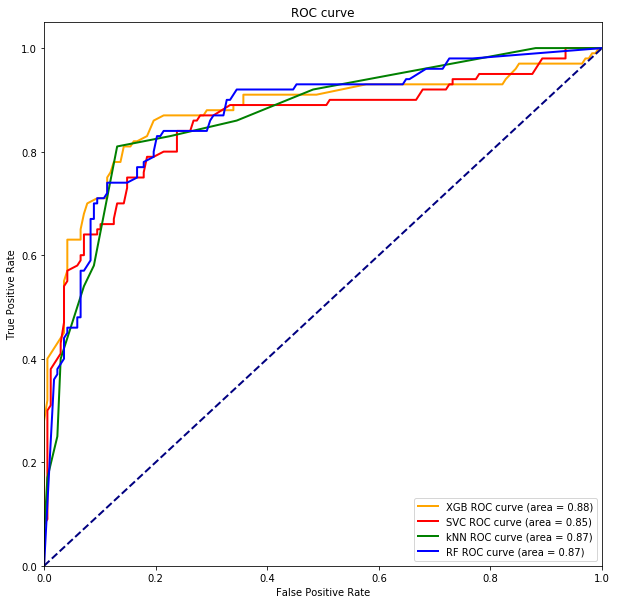

In [80]:
plt.figure(figsize=(10, 10))

plt.plot(xgb_fpr, xgb_tpr, color='orange', lw=2, label='XGB ROC curve (area = %0.2f)' % xgb_roc_auc)
plt.plot(svc_fpr, svc_tpr, color='red', lw=2, label='SVC ROC curve (area = %0.2f)' % svc_roc_auc)
plt.plot(knn_fpr, knn_tpr, color='green', lw=2, label='kNN ROC curve (area = %0.2f)' % knn_roc_auc)
plt.plot(rf_fpr, rf_tpr, color='blue', lw=2, label='RF ROC curve (area = %0.2f)' % rf_roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()

<br>

## 7. Hyperparameters Tuning

### 7-1. GridSearch

- kNN

In [81]:
from sklearn.model_selection import GridSearchCV

In [82]:
clf_kNN.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=13, p=2,
           weights='uniform')>

In [83]:
#parameter 설정
param_grid={'n_neighbors': np.linspace(1,21,11, dtype = int),
            'metric':  ['minkowski','euclidean','manhattan'],
            'weights' : ['uniform','distance']}


#GridSearch 설정
gs = GridSearchCV(clf_kNN, param_grid, scoring='accuracy', fit_params=None, 
                n_jobs=-1, cv=k_fold, verbose=False)
#모델 학습
gs.fit(X_train, y_train)

#점수 및 최적 parameter 도출
gs_test_score = accuracy_score(y_test, gs.predict(X_test))
print("Best Accuracy {:.3f} params {}".format(gs.best_score_, gs.best_params_))

Best Accuracy 0.819 params {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'distance'}


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CDAE91CDD8>,
      dtype=object)

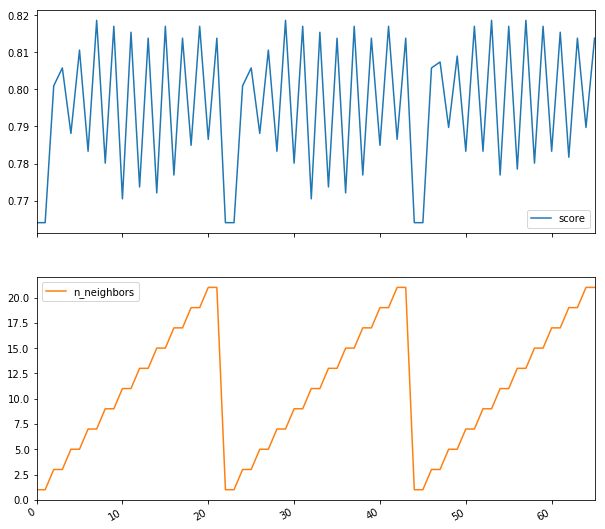

In [84]:
#parameter - 점수 시각화
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_n_neighbors'].data,
                                         gs.cv_results_['param_metric'].data,
                                         gs.cv_results_['param_weights'].data]),
                           columns=['score', 'n_neighbors', 'metric', 'weights'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

<br>

- RandomForest

In [85]:
clf_RF.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [86]:
#parameter 설정
param_grid={   'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'n_estimators': [130, 180, 230]}


#GridSearch 설정
gs = GridSearchCV(clf_RF, param_grid, scoring='accuracy', fit_params=None, 
                n_jobs=-1, cv=k_fold, verbose=False)
#모델 학습
gs.fit(X_train, y_train)

#점수 및 최적 parameter 도출
gs_test_score = accuracy_score(y_test, gs.predict(X_test))
print("Best Accuracy {:.3f} params {}".format(gs.best_score_, gs.best_params_))

Best Accuracy 0.828 params {'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 180}


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CDADEBECC0>,
      dtype=object)

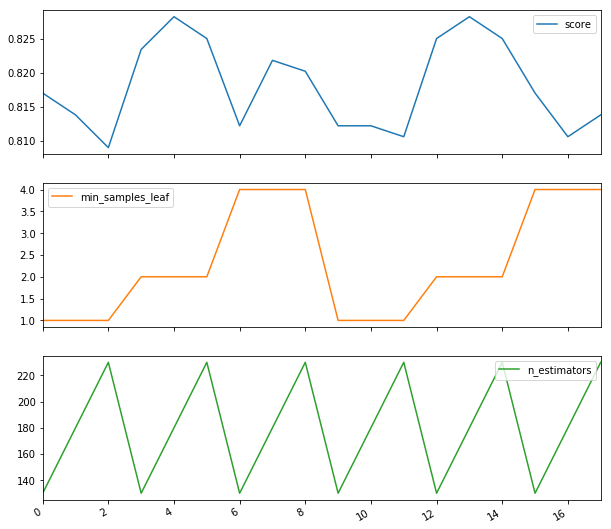

In [87]:
#결과 시각화
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_max_features'].data,
                                         gs.cv_results_['param_min_samples_leaf'].data,
                                         gs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'max_features', 'min_samples_leaf', 'n_estimators'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

<br>

### 7-2. Random Search

- kNN

In [88]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid_rand={'n_neighbors': randint(1,21),
            'metric':  ['minkowski','euclidean','manhattan'],
            'weights' : ['uniform','distance']}

rs=RandomizedSearchCV(clf_kNN, param_grid_rand, n_iter = 50, scoring='accuracy', fit_params=None, 
                n_jobs=-1, cv=k_fold, verbose=False, random_state=0)

rs.fit(X_train, y_train)

rs_test_score=accuracy_score(y_test, rs.predict(X_test))
print("Best Accuracy {:.3f} params {}".format(rs.best_score_, rs.best_params_))

Best Accuracy 0.819 params {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CDAE9D6A20>,
      dtype=object)

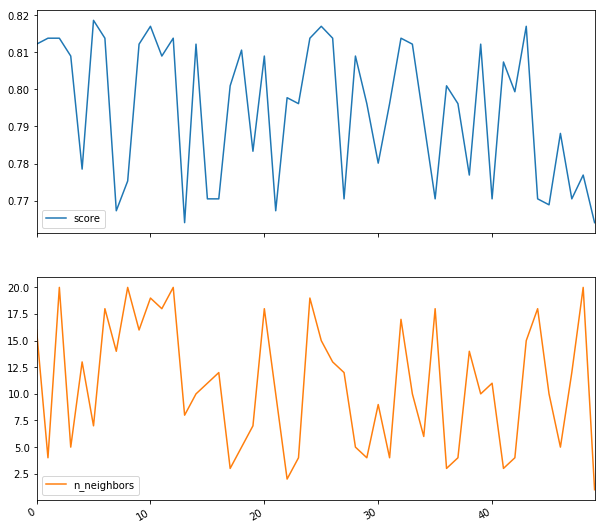

In [89]:
#결과 시각화
rs_results_df=pd.DataFrame(np.transpose([rs.cv_results_['mean_test_score'],
                                         rs.cv_results_['param_n_neighbors'].data,
                                         rs.cv_results_['param_metric'].data,
                                         rs.cv_results_['param_weights'].data]),
                           columns=['score', 'n_neighbors', 'metric', 'weights'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

- RandomForest

In [90]:
#parameter 설정
param_grid_rand={'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': randint(2,10),
               'n_estimators': randint(100,200)}


#RandomizedSearch 설정
rs=RandomizedSearchCV(clf_RF, param_grid_rand, n_iter = 50, scoring='accuracy', fit_params=None, 
                n_jobs=-1, cv=k_fold, verbose=False, random_state=0)
#모델 피팅
rs.fit(X_train, y_train)

#점수 표시
rs_test_score=accuracy_score(y_test, rs.predict(X_test))
print("Best Accuracy {:.3f} params {}".format(rs.best_score_, rs.best_params_))

Best Accuracy 0.835 params {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 121}


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CDAF111898>,
      dtype=object)

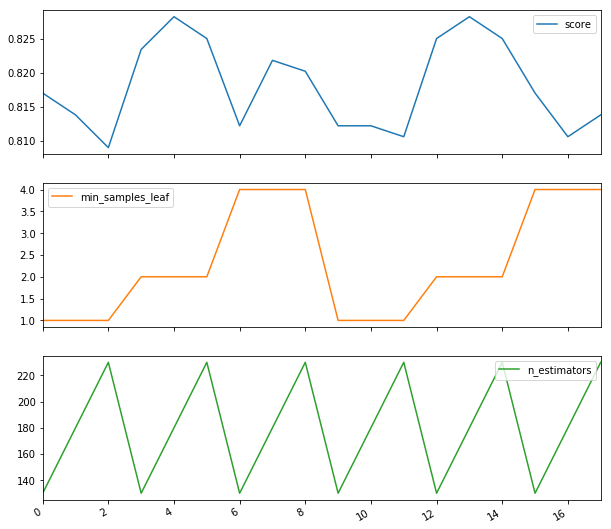

In [91]:
#결과 시각화
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_max_features'].data,
                                         gs.cv_results_['param_min_samples_leaf'].data,
                                         gs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'max_features', 'min_samples_leaf', 'n_estimators'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

<br>

## 8. Feature Importance

In [92]:
import seaborn as sns
import numpy as np
%matplotlib inline

In [93]:
#feature importance 추출
print("Feature importances: {0}".format(np.round(clf_DT.feature_importances_,3)))

Feature importances: [0.19  0.447 0.16  0.112 0.058 0.032]


In [94]:
#feature별 importance 매핑
for name, value in zip(X_train.columns, clf_DT.feature_importances_):
    print('{0} : {1: .3f}'.format(name, value))

Pclass :  0.190
Sex :  0.447
age_group :  0.160
fare_cat :  0.112
emb_cat :  0.058
companion :  0.032


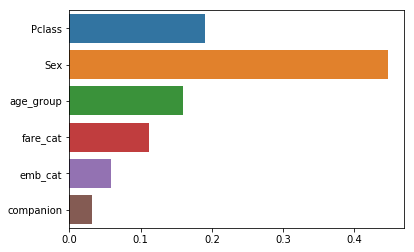

In [95]:
#feature importance를 column 별로 시각화하기
sns.barplot(x=clf_DT.feature_importances_, y=X_train.columns)